In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [2]:
train_data = pd.read_csv('orange_small_churn_train_data.csv')
test_data = pd.read_csv('orange_small_churn_test_data.csv')

In [3]:
train_data[-5:]

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
18294,18294,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,...,mErwEWL,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
18295,18295,NaN,NaN,NaN,NaN,NaN,1603.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c,NaN,1.0
18296,18296,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,Qcbd,ZI9m,55YFVY9,am7c,NaN,-1.0
18297,18297,NaN,NaN,NaN,NaN,NaN,210.0,0.0,NaN,NaN,...,wg_DmEs,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
18298,18298,NaN,NaN,NaN,NaN,NaN,343.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train_data.drop([18298], axis=0, inplace=True)

In [5]:
train_data[-5:]

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
18293,18293,NaN,NaN,NaN,NaN,NaN,3892.0,0.0,NaN,NaN,...,LsdaF5M,NaN,NaN,NaN,Xa3G,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
18294,18294,NaN,NaN,NaN,NaN,NaN,462.0,0.0,NaN,NaN,...,mErwEWL,LM8l689qOp,NaN,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0
18295,18295,NaN,NaN,NaN,NaN,NaN,1603.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,kG3k,uWr3,ZI9m,ib5G6X1eUxUn6,am7c,NaN,1.0
18296,18296,NaN,NaN,NaN,NaN,NaN,1239.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,Qcbd,ZI9m,55YFVY9,am7c,NaN,-1.0
18297,18297,NaN,NaN,NaN,NaN,NaN,210.0,0.0,NaN,NaN,...,wg_DmEs,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [6]:
numeric_train = train_data.iloc[:, 1:191].fillna(0)
numeric_test = test_data.iloc[:, 1:191].fillna(0)
categorial_train = train_data.iloc[:, 191:-1]
categorial_test = test_data.iloc[:, 191:-1]
y = train_data.iloc[:, 231]

Объединим обучающую и тестовую выборки категориальных признаков методом LabelEncoder, чтобы вместе их перекодировать, затем снова разделим.

In [7]:
categorial_train.shape

(18298, 40)

In [8]:
categorial = pd.concat([categorial_train, categorial_test], axis=0)

In [9]:
categorial.shape

(28298, 40)

In [10]:
categorial_encode = categorial.fillna('?').apply(LabelEncoder().fit_transform)

In [11]:
categorial_train_encode = categorial_encode.iloc[:18298, :]
categorial_test_encode = categorial_encode.iloc[18298:, :]

Объединим кодированные признаки с вещественными и для обучающей и для тестовой выборок.

In [12]:
X_train = pd.concat([numeric_train, categorial_train_encode], axis=1)
X_test = pd.concat([numeric_test, categorial_test_encode], axis=1)

Бдуем использовать StratifiedKFold на 10 фолдов.

In [13]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 17)

Обучим градиентный бустинг со стандартными параметрами. Сделаем предсказания на тестовой выборке, сохраним результат в файл и отправим на kaggle.

In [50]:
xgb_class = xgb.XGBClassifier()

In [51]:
pred = xgb_class.fit(X_train, y).predict_proba(X_test)

In [52]:
answers1 = pd.DataFrame({'ID':range(0, pred.shape[0]), 'result':pred[:, 1]})
answers1.to_csv('XGBoost1.csv', sep = ',', index=False)

Получим результат: 0.68371, мы уже побили бейслайн=0.66710, но можно лучше. Подберем параметры с помощью grid_search

In [56]:
xgb_class.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [57]:
parameters_grid = {
    'n_estimators' : [50, 100, 200],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.2, 0.5, 1]
}

In [58]:
grid_cv = GridSearchCV(xgb_class, parameters_grid, scoring = 'roc_auc', cv = cv, n_jobs=-1)

In [59]:
%time grid_cv.fit(X_train, y)

Wall time: 8min 52s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                

In [60]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.7284930739012925
{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100}


Сделаем предсказание на модели с лучшими параметрами, запишем в файл и отправим на kaggle

In [70]:
pred2 = grid_cv.best_estimator_.predict_proba(X_test)

In [72]:
answers2 = pd.DataFrame({'ID':range(0, pred2.shape[0]), 'result':pred2[:, 1]})
answers2.to_csv('XGBoost2.csv', sep = ',', index=False)

Получили результат: 0.70460

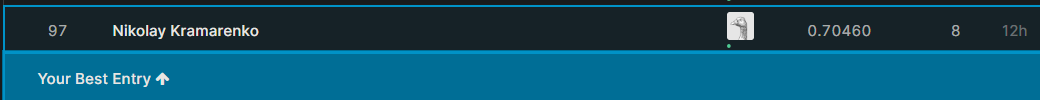